In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi

Wed Mar  1 02:51:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    21W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import warnings
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [4]:
import torch
from torch.distributions import constraints

from pyro.contrib.gp.kernels.kernel import Kernel
from pyro.nn.module import PyroParam


def _torch_sqrt(x, eps=1e-12):
    """
    A convenient function to avoid the NaN gradient issue of :func:`torch.sqrt`
    at 0.
    """
    # Ref: https://github.com/pytorch/pytorch/issues/2421
    return (x + eps).sqrt()


class Isotropy(Kernel):
    """
    Base class for a family of isotropic covariance kernels which are functions of the
    distance :math:`|x-z|*l`, where :math:`l` is the length-scale parameter.

    By default, the parameter ``lengthscale`` has size 1. To use the isotropic version
    (different lengthscale for each dimension), make sure that ``lengthscale`` has size
    equal to ``input_dim``.

    :param torch.Tensor lengthscale: Length-scale parameter of this kernel.
    """

    def __init__(self, input_dim, variance=None, lengthscale=None, active_dims=None):
        super().__init__(input_dim, active_dims)

        variance = torch.tensor(1.0) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

        lengthscale = torch.tensor(1.0) if lengthscale is None else lengthscale
        self.lengthscale = PyroParam(lengthscale, constraints.positive)

    def _square_scaled_dist(self, X, Z=None):
        r"""
        Returns :math:`\|\frac{X-Z}{l}\|^2`.
        """
        if Z is None:
            Z = X
        X = self._slice_input(X)
        Z = self._slice_input(Z)
        if X.size(1) != Z.size(1):
            raise ValueError("Inputs must have the same number of features.")

        scaled_X = X * self.lengthscale
        scaled_Z = Z * self.lengthscale
        X2 = (scaled_X ** 2).sum(1, keepdim=True)
        Z2 = (scaled_Z ** 2).sum(1, keepdim=True)
        XZ = scaled_X.matmul(scaled_Z.t())
        r2 = X2 - 2 * XZ + Z2.t()
        return r2.clamp(min=0)

    def _scaled_dist(self, X, Z=None):
        r"""
        Returns :math:`l * \|X-Z\|`.
        """
        return _torch_sqrt(self._square_scaled_dist(X, Z))

    def _diag(self, X):
        """
        Calculates the diagonal part of covariance matrix on active features.
        """
        return self.variance.expand(X.size(0))


class INV_RBF(Isotropy):
    r"""
    Implementation of Radial Basis Function kernel:

        :math:`k(x,z) = \sigma^2\exp\left(-0.5 \times \frac{|x-z|^2}{l^2}\right).`

    .. note:: This kernel also has name `Squared Exponential` in literature.
    """

    def __init__(self, input_dim, variance=None, lengthscale=None, active_dims=None):
        super().__init__(input_dim, variance, lengthscale, active_dims)

    def forward(self, X, Z=None, diag=False):
        if diag:
            return self._diag(X)

        r2 = self._square_scaled_dist(X, Z)
        return self.variance * torch.exp(-0.5 * r2)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [6]:
# p(y) = X1-X2-1/2*X3+1/4*X4+1/8*X5+1/16*X6

In [7]:
#PCA
start_time = time.time()
np.random.seed(0)
L_0 = []
N = 500
k= 6
X = np.random.randn(N,k)
f_samples = X @ np.array([1,-1,-1/2,1/4,1/8,1/16])
p_samples = 1/(1+np.exp(-f_samples)) #logit link samples
y_samples = np.random.binomial(1, p_samples) #Sample y from underlying latent function
y_samples = y_samples.squeeze()
X = X.reshape(-1,k)
for _ in range(50):
    X = np.insert(X,0,np.random.randn(N),axis=1)
pca = PCA()
inert = 20
pca_x = pca.fit_transform(X)[:,-inert:]
scaler = StandardScaler()
pca_x = scaler.fit_transform(pca_x)
for random_seed in range(inert):
#         np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    X_ = np.insert(X,0,pca_x[:,random_seed],axis=1)
    p = X_.shape[1]
    X_ = torch.tensor(X_).to(device)
    y_samples = torch.tensor(y_samples,dtype= torch.float32).to(device)
    kernel = INV_RBF(input_dim = p, variance = torch.tensor(1.).to(device),lengthscale = torch.ones(p).to(device))
    likelihood = gp.likelihoods.Binary()
    gpc = gp.models.VariationalGP(X_,y_samples,kernel=kernel,jitter = torch.tensor(1e-04).to(device), 
                                likelihood=likelihood,
                                whiten =True)
    gpc.kernel.lengthscale =  pyro.nn.PyroSample(dist.Exponential(torch.tensor([2.0]).to(device)).expand([p]).to_event(1))
    gpc.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0).to(device), torch.tensor(2.0).to(device)))
    num_steps = 1000
    initial_lr = 0.005
    gamma = 0.5  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / num_steps)
    optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

    svi = SVI(gpc.model,gpc.guide,optim,loss=Trace_ELBO())
    losses =np.zeros(num_steps)

    pyro.clear_param_store()
    for i in range(num_steps):
        losses[i]=svi.step()

    L_0.append(pyro.param('kernel.lengthscale_map').data.cpu().numpy())


In [8]:
L_0 = np.array(L_0)

In [9]:
L_order = np.concatenate(  (L_0[:,-6:],L_0[:,1:5]), axis = 1)

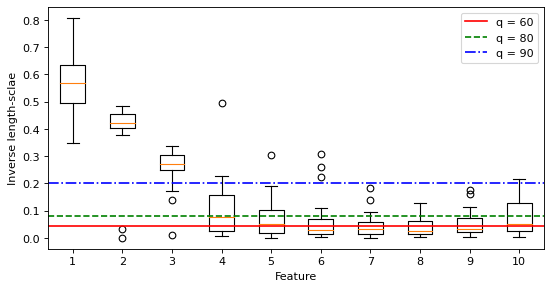

In [10]:
plt.figure(figsize = (8,4),dpi = 80)
plt.boxplot(L_order)
plt.axhline(np.quantile(L_0[:,0],0.6),c='r',ls='-',label = 'q = 60')
plt.axhline(np.quantile(L_0[:,0],0.8),c='g',ls='--',label = 'q = 80')
plt.axhline(np.quantile(L_0[:,0],0.9),c='b',ls='-.',label = 'q = 90')
plt.xlabel('Feature')
plt.ylabel('Inverse length-sclae')
plt.legend()
plt.show()